## This code is an experiment only, it's not ready for analysis. This notebook attempts to generate 2 images of a water body: one for when the water is rising and one for when the water is receeding on the floodplain. 

This was done by firstly generating a hydrograph, then choosing a threshold for flow (ie we are only interested in higher flows that represent flooding events). All satellite images corresponding to days when the flow level was higher than the threshold were retrieved from the WOfS database. Then it was attempted to separate the dates into 2 lists: one for days when the water was rising and one for days when the water was receeding. This was done by using a decision tree that checked if the day of the pass had a higher or lower reading than the gauge reading 21 days later. If the gauge reading 21 days after the pass was higher, that pass was put in the rising category. If it was lower, it was put in the receeding category. Then an image of each dataset was generated to show the difference between rising water and receeding water. This notebook is not intended to be used for analysis, it is an experiment only. 

In [1]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import datacube

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff


%matplotlib inline

import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

This step reads a csv file from the BOM's Water Data Online website. It will tell you the location of the gauge, which is the area an image will be generated for. The buffer is how many meters radius around the gauge do you want to generate an image of.

In [2]:
#Where abouts is your csv file located? It needs to be somewhere in your sandbox to run. 
csv_file_location = 'Boundary_Bend.csv'
station_location = pd.read_csv(csv_file_location, skiprows=1, nrows=2, escapechar='#')

lat = station_location.iloc[0][1]
lon = station_location.iloc[1][1]

buffer = 8000

lat, lon

(-34.71966901, 143.1698626)

Now it will generate a hydrograph and the user can enter a threshold of flow they are interested in (eg we are only interested in data representing flooding events over 300 cubic meters a second).

Here is a hydrograph of the gauge data. The y axis is in cubic meters per second. Please choose a threshold in the box below.


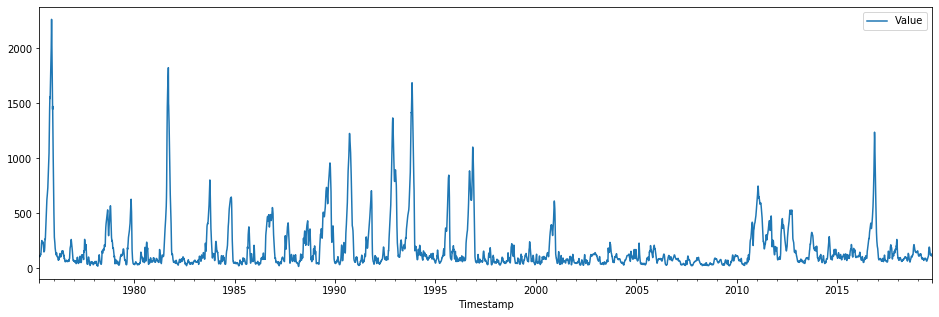

In [3]:
#reading gauge data, setting index as Timestamp
gauge_data = pd.read_csv(csv_file_location,
                error_bad_lines = False, skiprows=9, escapechar='#',
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'), #Tells it to set Timestamp as the index column
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))

#delete unnecessary columns
gauge_data = gauge_data.drop(columns='Interpolation Type')
gauge_data = gauge_data.drop(columns='Quality Code')

gauge_data.plot(figsize=(16, 5))

print("Here is a hydrograph of the gauge data. The y axis is in cubic meters per second. Please choose a threshold in the box below.")

Once you enter the threshold and run this box, it will retrieve all the days that had a satellite pass during the high gauge readings. It will tell you how many satellite passes there are.

In [4]:
#set threshold for flow rate
yaxis_lower_parameter = 300

#Dask loading wofs_albers data
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1988-01-01', '2019-08-22'), 
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

#convert Pandas dataframe to xArray for merging with WOfS
gauge_data_xr = gauge_data.to_xarray() 

#this is the xArray merge function
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time) 

#Now define the passes to load based on user input
specified_satellite_passes = merged_data.where((merged_data.Value > yaxis_lower_parameter), drop=True)
specified_satellite_passes = specified_satellite_passes.drop('Timestamp')

date_list = specified_satellite_passes.time.values

#Check how many passes you are about to load. I recommend loading 100 to 400 passes.
print("I would recommend loading 100 to 400 passes\n")
print("You are about to load this many passes:{}".format(specified_satellite_passes.time.shape[0]))

I would recommend loading 100 to 400 passes

You are about to load this many passes:180


The box below will load and cloud mask these satellite passes. It will generate a hydrograph showing where there were clear satellite passes. 

Here is the hydrograph displaying the chosen threshold and days for which there were clear satellite passes above this threshold.


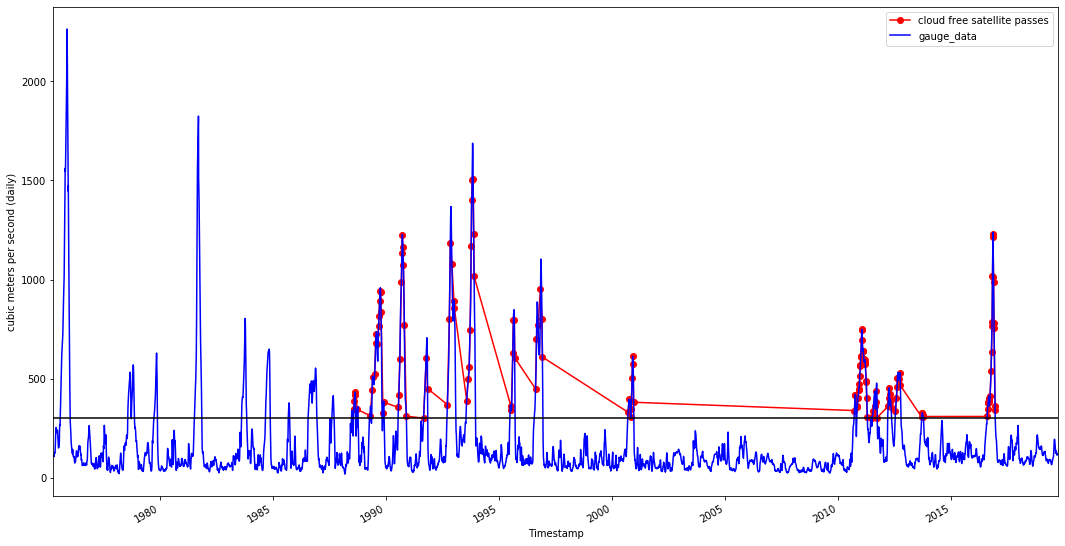

In [5]:
# load the passes that happened during the specified flow parameters
specified_passes = wofs_albers.sel(time=date_list).compute()

# Cloud mask
cc = masking.make_mask(specified_passes.water, cloud=True)
npixels_per_slice = specified_passes.water.shape[1]*specified_passes.water.shape[2]
npixels_per_slice
ncloud_pixels = cc.sum(dim='x').sum(dim='y')
cloud_pixels_fraction = (ncloud_pixels/npixels_per_slice)
clear_specified_passes = specified_passes.water.isel(time=cloud_pixels_fraction<0.3)

#Now take the clear passes and make a pandas dataframe that lists time of clear passes and corresponding gauge value
clear_specified_passes_pd = clear_specified_passes.time.to_dataframe()
clear_specified_passes_pd = clear_specified_passes_pd.rename(columns = {'time': 'date'})#can't have 2 columns called time
merged_data_pd = merged_data.to_dataframe()

#Merge clear satellite passes with gauge data by the time dimension
clear_merged_data = pd.merge(clear_specified_passes_pd, merged_data_pd, left_on= 'time', 
                            right_index=True, how='inner')
clear_merged_data = clear_merged_data.drop(columns='date')
clear_merged_data = clear_merged_data.drop(columns='Timestamp')

#Plot the clear satellite passes over the hydrograph
ax = clear_merged_data.plot(marker = 'o', color='red', figsize=(18,10))
plt.ylabel('cubic meters per second (daily)')
gauge_data.plot(ax=ax, color='blue')
plt.axhline(yaxis_lower_parameter, color='black') #putting a black line to show the chosen threshold
ax.legend(["cloud free satellite passes", "gauge_data"]);

print("Here is the hydrograph displaying the chosen threshold and days for which there were clear satellite passes above this threshold.")

## Now separate the gauge data into 2 lists: rising and falling
### User selects what the multiplier and procedent should be
Splitting the data into rising and falling is quite hard. One option would be to use a numpy peak picking function and identify the passes on each side of the peak. This would require someone who can code numpy much better than I can. Instead I have used a method similar to the one MDBA has used previously for comparing rising to falling flows. This box will check whether the gauge-reading 21 days after the satellite pass was higher or lower than the day of the satellite pass. The multiplier represents by how much more the water should be lower or higher to be considered a significant change. I've just left it as 1 for simplicity. It puts the pass either into the rising or falling list accordingly. It runs a loop to do this for every single pass. The output will tell you how many passes you got in each list. 

In [15]:
#The multiplier specifies by how much more the flow rate has to rise by to be considered a significant rise
multiplier = 1

#The procedent is how many days in advance the algorithm checks for a rise or fall. 
#one day is not enough beacuse the data is too noisy to just do 1 day. 21 days is suggested. 
days_ahead = 21

#extract the flow rate values from the gauge data for the loop
gauge_data_values = gauge_data['Value']
gauge_data_values = gauge_data_values.where(gauge_data_values > yaxis_lower_parameter)
gauge_data_values = gauge_data_values.dropna()

i = 0
rising_list = []
falling_list = []
for value in gauge_data_values[:len(gauge_data_values)-days_ahead]:
    if value < gauge_data_values[i+days_ahead]*multiplier:
        rising_list.append(gauge_data_values.index[i])
    else:
        falling_list.append(gauge_data_values.index[i])
    i = i + 1
    
#set time in the Timestamp to 00:00:00 to match gauge Timestamps
pass_dates = clear_merged_data.index
pass_dates_list = pass_dates.tolist()

ii = 0
pass_list = []
for time in pass_dates_list:
    pass_list.append(pass_dates_list[ii].replace(hour=0, minute=0, second=0, microsecond=0))
    ii = ii + 1

#match the date lists up to the satellite passes
rising_passes = set(rising_list) & set(pass_list)
rising_passes = list(rising_passes)
falling_passes = set(falling_list) & set(pass_list)
falling_passes = list(falling_passes)

print("number of rising passes: {}".format(len(rising_passes)))
print("number of falling passes: {}".format(len(falling_passes)))

number of rising passes: 75
number of falling passes: 68


## generate an image of the rising passes and a second one of the falling passes

Now we'll make an image that represents the frequency of water for each list. The rising image will take all the satellite images from the rising list and layer them to create a summary image of what the river looked like on days that we specified that the water level was rising, and same same for the falling list. 

number of rising passes: 75
number of falling passes: 68


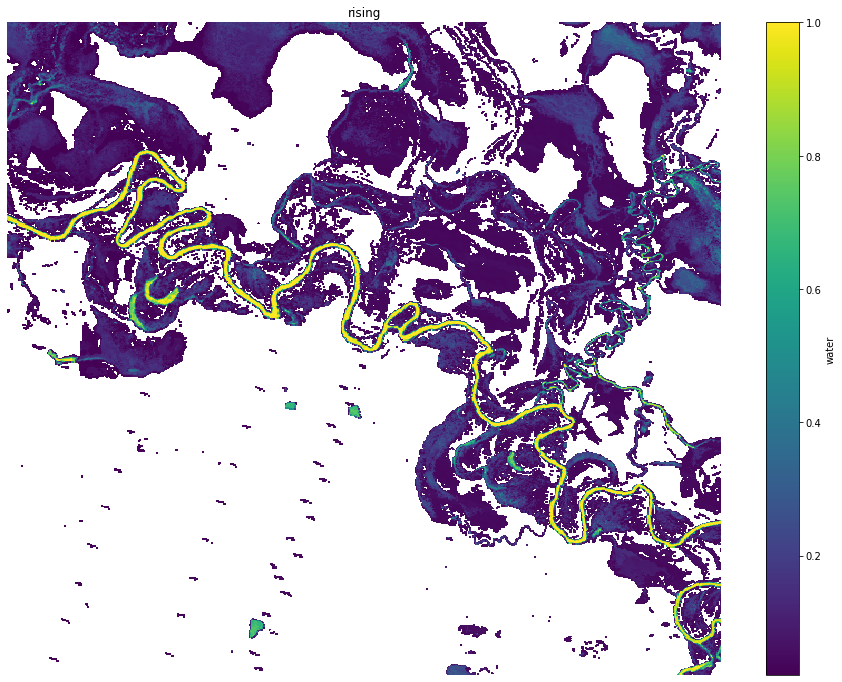

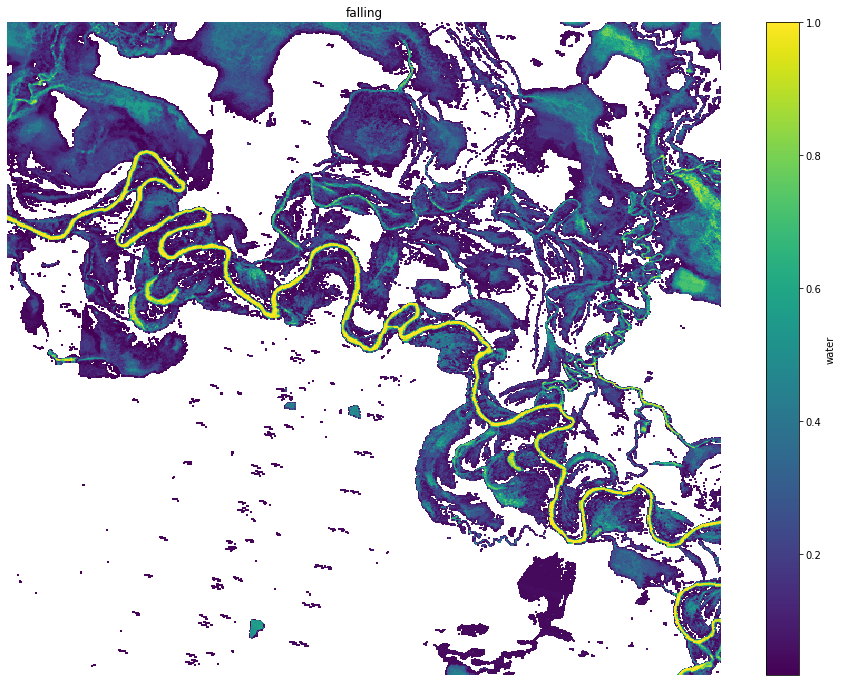

In [16]:
rising_picture = clear_specified_passes.reindex(time=rising_passes,
                                                        method='nearest',tolerance=np.timedelta64(1,'D'))
falling_picture = clear_specified_passes.reindex(time=falling_passes,
                                                        method='nearest',tolerance=np.timedelta64(1,'D'))

wet = (rising_picture == 128).sum(dim='time')
dry = (rising_picture == 0).sum(dim='time')
clear = wet + dry
frequency = wet / clear
frequency= frequency.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency = frequency.where(frequency!=0) #This is to tell it to make areas that were dry 100% of the time white

frequency.plot(figsize = (16, 12))
plt.axis('off')
plt.title('rising')

wet = (falling_picture == 128).sum(dim='time')
dry = (falling_picture == 0).sum(dim='time')
clear = wet + dry
frequency = wet / clear
frequency = frequency.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency = frequency.where(frequency!=0) #This is to tell it to make areas that were dry 100% of the time white

frequency.plot(figsize = (16, 12))
plt.axis('off')
plt.title('falling')

print("number of rising passes: {}".format(len(rising_passes)))
print("number of falling passes: {}".format(len(falling_passes)))